# Support Vector Machines (SVM)

Oggi implementiamo un programma per la classificazione usando una support vector machine (SVM).

Per i dettagli su cosa è una SVM potete vedere i riferimenti alla fine di questo articolo.

L'algoritmo di SVM che useremo è già implementato nel package [scikit-learn](https://scikit-learn.org/stable/) (sklearn per gli amici).
Nel gergo di sklearn viene sottolineato che si tratta di una classificazione, per cui viene chiamato support vector classifier (SVC).

Importiamo la libreria per una SVC lineare, quindi che usa un kernel lineare (o nessun kernel, a seconda della terminologia preferita):

In [1]:
from sklearn.svm import LinearSVC

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer

## Load dataset

Carico i dati dal foglio Excel

In [3]:
exc1 = pd.read_csv('diabetes.csv')

In [4]:
exc2 = pd.read_csv('doctors.csv', encoding = "ISO-8859-1")

Vediamo cosa contengono i due dataframe appena creati:

In [5]:
exc1.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [6]:
exc2.head()

,PatientID,Physician
0,1000038,Jeanne Vestergaard
1,1000069,Sheldon Comeaux
2,1000118,Brain Dulaney
3,1000183,Alaine Poisson
4,1000326,Erik Collado


Nel primo dataframe ho una serie di dati riguardanti i pazienti e la label **Diabetic**, che indica se il paziente è diabetico o meno.
Il secondo dataframe contiene l'informazione dottore per ogni paziente.
Il modello che vogliamo costruire deve essere in grado di prevedere se il paziente è diabetico, sulla base dei dati anamnesici e delle misure mediche del paziente.

## Preprocessing dei dati

I due dataframe exc1 e exc2 contengono tutti e due un PatientID, per cui devo concatenare i due dataframe orizzontalmente in base al PatientID.

In [7]:
lista_pazienti = pd.merge(exc1, exc2, on='PatientID', how='outer')
lista_pazienti.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0,Dan Drayton
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0,Anthony Frizzell
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0,Gordon Fredrickson
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1,Chad Corbitt
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0,Zachary Fellows


Vediamo un riassunto delle proprietà statistiche del dataframe.

In [8]:
lista_pazienti.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


Salta subito all'occhio che la funzione ha fatto la statistica anche di PatientID, che è un codice numerico rappresentante il paziente pertanto dovrebbe essere considerato come una stringa piuttosto che un numero.<br>
Cambio il tipo dei dati con la funzione astype()

In [9]:
lista_pazienti['PatientID'] = lista_pazienti['PatientID'].astype(str)

Vediamo quali sono le colonne aventi dati numerici, usiamo la funzione select_dtypes(). Verifichiamo che PatientID non è tra questi.

In [10]:
lista_pazienti.select_dtypes(include='number').head()

,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,0,171,80,34,23,43.509726,1.213191,21,0
1,8,92,93,47,36,21.240576,0.158365,23,0
2,7,115,47,52,35,41.511523,0.079019,23,0
3,9,103,78,25,304,29.582192,1.282870,43,1
4,1,85,59,27,35,42.604536,0.549542,22,0


Ci sono elementi non definiti (nan) nelle righe? Possiamo usare la funzione <strong>count</strong>. 

In [11]:
lista_pazienti.count()

PatientID                 15000
Pregnancies               15000
PlasmaGlucose             15000
DiastolicBloodPressure    15000
TricepsThickness          15000
SerumInsulin              15000
BMI                       15000
DiabetesPedigree          15000
Age                       15000
Diabetic                  15000
Physician                 15000
dtype: int64

Il dataframe ha 15000 righe ed ogni campo(o colonna) ha 15000 elementi. Quindi apparentemente non ci sono <strong>nan</strong>. Dico apparentemente perché potrebbero essere stati definiti con una codifica particolare, per esempio usando un numero molto negativo (-999) per l'indice di massa corporea (BMI), quando questo può essee un valore solo positivo.<br>
Per riconoscere questi casi particolari dovremmo esplorare visualmente il dataframe e in caso scrivere un codice ad hoc.

Vediamo la distribuzione dei valori per ogni colonna. Per questo userò la funzione <strong>distplot()</strong> del pacchetto seaborn.

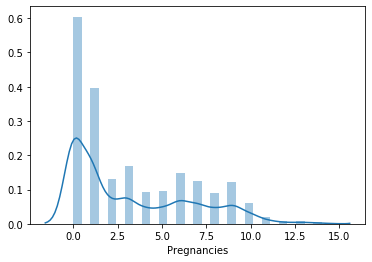

In [12]:
sns.distplot(lista_pazienti.Pregnancies)
plt.show()

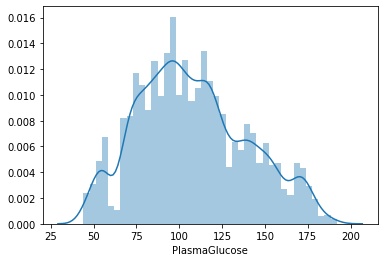

In [13]:
sns.distplot(lista_pazienti.PlasmaGlucose)
plt.show()

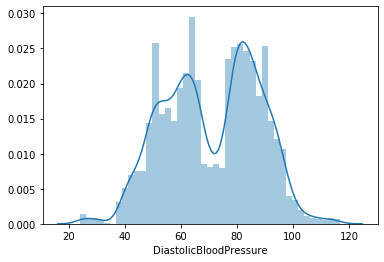

In [14]:
sns.distplot(lista_pazienti.DiastolicBloodPressure)
plt.show()

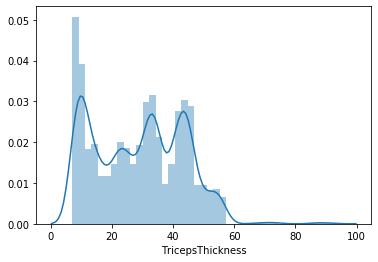

In [15]:
sns.distplot(lista_pazienti.TricepsThickness)
plt.show()

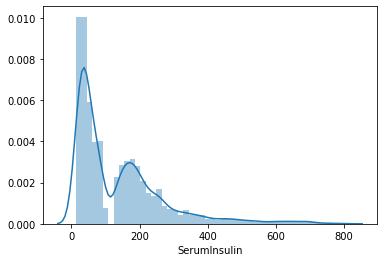

In [16]:
sns.distplot(lista_pazienti.SerumInsulin)
plt.show()

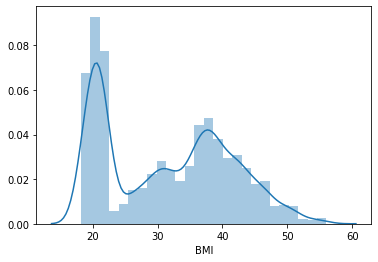

In [17]:
sns.distplot(lista_pazienti.BMI)
plt.show()

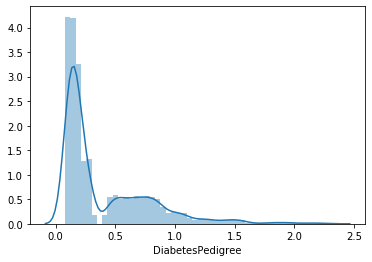

In [18]:
sns.distplot(lista_pazienti.DiabetesPedigree)
plt.show()

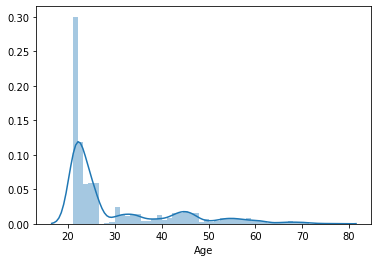

In [19]:
sns.distplot(lista_pazienti.Age)
plt.show()

Poiché il campo dell'età (Age) è piuttosto sbilanciato, il tutorial di Edx suggeriva di usare log(Age) al suo posto.<br>
Aggiungiamo una colonna con log(Age):

In [20]:
lista_pazienti['logAge'] = np.log10(lista_pazienti['Age'].values)

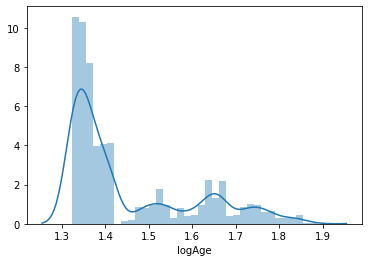

In [21]:
sns.distplot(lista_pazienti.logAge)
plt.show()

Adesso voglio normalizzare i dati perché la convergenza è più facile quando i dati sono normalizzati.

La normalizzazione avviene per colonna. Per le colonne che hanno una distribuzione simile a quella gaussiana (o normale), posso normalizzare usando lo Z-score, ovvero si calcola la media ($\mu$) e la varianza ($\sigma^2$) dei dati in una colonna e poi si normalizza ogni singolo elemento della colonna secondo:
\begin{equation*}
\hat{x_i} = \frac{(x_i - \mu)}{\sigma^2} \quad \forall i
\end{equation*}

Per le colonne che non hanno una distribuzione simil-gaussiana posso usare una normalizzazione max-min. Ovvero calcolo il max dei dai su una colonna ($M$) e il minimo ($m$) degli stessi. Dopodichè applico la normalizzazione:
\begin{equation*}
\hat{x_i} = \frac{(x_i - m)}{(M-m)} \quad \forall{i}
\end{equation*}

Per fortuna non dobbiamo farlo manualmente, ma possiamo usare le funzioni di scikit-learn StandardScaler() e MinMaxScaler().

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Definisco su quali colonne usare l'algoritmo MinMax e su quali lo Zscore (che in scikit-learn si chiama StandardScaler):

In [23]:
columns_minmax = ['Pregnancies','SerumInsulin','BMI','DiabetesPedigree','logAge']
columns_zscore = ['PlasmaGlucose','DiastolicBloodPressure','TricepsThickness']

In [24]:
mmsc = MinMaxScaler()
stsc = StandardScaler()

In [25]:
lista_pazienti_norm = pd.DataFrame(index=range(15000))
for column in columns_minmax:
    lista_pazienti_norm[column + '_norm'] = mmsc.fit_transform(lista_pazienti[column].values.astype(np.float64).reshape(-1, 1))
for column in columns_zscore:
    lista_pazienti_norm[column + '_norm'] = stsc.fit_transform(lista_pazienti[column].values.astype(np.float64).reshape(-1, 1))

lista_pazienti_norm[lista_pazienti.select_dtypes(exclude='number').columns] = lista_pazienti.select_dtypes(exclude='number')   #colonne non mumeriche

lista_pazienti_norm['Diabetic'] = lista_pazienti['Diabetic']   #È la label del modello

In [26]:
lista_pazienti_norm.head()

,Pregnancies_norm,SerumInsulin_norm,BMI_norm,DiabetesPedigree_norm,logAge_norm,PlasmaGlucose_norm,DiastolicBloodPressure_norm,TricepsThickness_norm,PatientID,Physician,Diabetic
0,0.000000,0.011465,0.668952,0.510511,0.000000,1.974401,0.523884,0.356298,1354778,Dan Drayton,0
1,0.571429,0.028025,0.080352,0.036123,0.070017,-0.495823,1.299626,1.249448,1147438,Anthony Frizzell,0
2,0.500000,0.026752,0.616137,0.000438,0.070017,0.223356,-1.445306,1.592967,1640031,Gordon Fredrickson,0
3,0.642857,0.369427,0.300831,0.541848,0.551595,-0.151868,0.404539,-0.262036,1883350,Chad Corbitt,1
4,0.071429,0.026752,0.645027,0.212047,0.035804,-0.714703,-0.729237,-0.124629,1424119,Zachary Fellows,0


Un'ultima considerazione. Il valore di PatientID probabilmente non influisce sul risultato. Cioè non dovrebbe esserci alcuna correlazione tr il PatientID e la label (Diabetic).

Invece potrebbe esserci correlazione tra il medico (Physician) e il fatto che il paziente sia diabetico. Un cattivo medico aumenta la probabilità che il paziente si ammali. Per cui decido di usare l'informazione sul nome del medico.

Come primo passo voglio vedere quanti sono i medici nella lista. Utilizzo la funzione unique() per vedere quali sono i valori unici della colonna Physician. E shape per contarli. 

In [27]:
lista_pazienti_norm.Physician.unique().shape

(109,)

In tutto ho 109 medici. 109 medici su 15000 dati... può essere che ci sia una correlazione.

La regressione logistica è un algoritmo puramente matematico, che fa uso di numeri per determinare una uscita. Se voglio usare la colonna Physician, devo trasformare i valori in una informazione numerica che possa essere usata dall'algoritmo. 

Per fare questo uso il one-hot-encoding. Scikit-learn ha una funzione per realizzare l'encoding, si chiama LabelBinarizer() 

In [28]:
lb = LabelBinarizer()
Phis_ohe = lb.fit_transform(lista_pazienti_norm.Physician)
Phis_ohe.shape

(15000, 109)

L'output di LabelBinarizer() è un array bidimensionale. Per comodità voglio mettere tutti i dati in un dataframe, per cui devo dare un nome a ciscuna delle colonne di Phis_ohe.

In [29]:
columns_name = []
for i in range(109):
    columns_name += ['phis_ohe' + str(i)]

Creo il dataframe con i dati Phis_ohe e i nomi delle colonne columns_name

In [30]:
lista_dottori = pd.DataFrame(Phis_ohe, columns=columns_name)

Concateno la lista dei pazienti e quella dei dottori, poichè l'ordine delle righe non è cambiato, posso semplicemente accostarle una con l'altra (axis=1):

In [31]:
lista_pazienti_e_dottori = pd.concat([lista_pazienti_norm, lista_dottori], axis=1)

Dal dataframe devo rimuovere alcune colonne

In [32]:
#rimuovo la colonna Physician che è stata rimpiazzata dalla stessa informazione codificata
#rimuovo la colonna PatientID perché non è informativa
#rimuovo la colonna Diabetic perché costituisce il dato da predire
lista_pazienti_e_dottori = lista_pazienti_e_dottori.drop(columns=['Physician','PatientID','Diabetic'])

In [33]:
lista_pazienti_e_dottori.head()

,Pregnancies_norm,SerumInsulin_norm,BMI_norm,DiabetesPedigree_norm,logAge_norm,PlasmaGlucose_norm,DiastolicBloodPressure_norm,TricepsThickness_norm,phis_ohe0,phis_ohe1,...,phis_ohe99,phis_ohe100,phis_ohe101,phis_ohe102,phis_ohe103,phis_ohe104,phis_ohe105,phis_ohe106,phis_ohe107,phis_ohe108
0,0.000000,0.011465,0.668952,0.510511,0.000000,1.974401,0.523884,0.356298,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.571429,0.028025,0.080352,0.036123,0.070017,-0.495823,1.299626,1.249448,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.500000,0.026752,0.616137,0.000438,0.070017,0.223356,-1.445306,1.592967,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.642857,0.369427,0.300831,0.541848,0.551595,-0.151868,0.404539,-0.262036,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.071429,0.026752,0.645027,0.212047,0.035804,-0.714703,-0.729237,-0.124629,0,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
lista_pazienti_e_dottori.shape

(15000, 117)

In realtà, rimane aperta una questione. Come trattare i pazienti che hanno più di una riga? Probabilmente si tratta di pazienti che hanno registrato dati in momenti diversi, in due viste diverse. Al momento decido di non riservare a questi pazienti un particolare trattamento, cioè li tratto come se fossero due pazienti diversi con dati diversi. In effetti dando un'occhiata veloce, lo stesso paziente può avere dati molto diversi tra loro. <br>
Questi sono i pazienti duplicati:

In [35]:
lista_pazienti.loc[lista_pazienti.PatientID.duplicated(),:].head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,Physician,logAge
72,1912150,8,133,59,12,477,42.477097,0.858930,21,1,Noreen Branch,1.322219
205,1854671,1,53,78,44,29,18.413402,0.127919,23,0,Demi Vadeboncoeur,1.361728
377,1192134,0,92,50,31,39,38.658578,0.664133,23,0,Carolos Lamy,1.361728
417,1366655,5,106,67,44,77,29.835662,0.177607,22,1,Eleanor Bryan,1.342423
458,1455760,7,121,53,35,312,19.824888,0.114730,21,0,Rocco Yarborough,1.322219


## Partizionare il dataset

Divido i dati di ingresso in un set per il training e un set per il test.<br>
Per farlo utilizzo la funzione train_test_split() di scikit-learn

In [36]:
from sklearn.model_selection import train_test_split

input_data = lista_pazienti_e_dottori.values.astype(np.float32) #le operazioni con i tensori richiedono il tipo float
label_data = lista_pazienti.Diabetic.values.astype(np.float32)

input_data_train, input_data_test, label_train, label_test = train_test_split(input_data, label_data, test_size=0.3)

## Definizione del modello

Definisco il modello di SVM (o SVC) lineare. Il parametro più importante del modello e il fattore C che ha lo stesso ruolo dell'inverso del fattore di penalizzazione della **ridge regression** (*l2* penalized logistic regression).
Con un valore molto alto di C c'è il rischio di overfitting. Un valore basso di C tende a non considerare gli outliers.

Per i dettagli della implementazione nel pacchetto scikit-learn della SVM vedi la documentazione originale del [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

Iniziamo a settare C=1

In [37]:
svc = LinearSVC(C=1)

In [38]:
label_train.shape, input_data_train.shape

((10500,), (10500, 117))

In [39]:
model = svc.fit(input_data_train, label_train)

In [40]:
output_data_train = model.predict(input_data_train)
output_data_test = model.predict(input_data_test)

Definiamo come funzione errore la funzione Binary Cross Entropy BCELoss(), questa è cosi definita:
error(x) = \sum_{i=1}^n \left( 2 \recht)
\begin{equation}
error(x) = \sum_{k=1}^n \left[ -y \cdot log(h(x)) - (1-y) \cdot log(1-h(x)) \right]
\end{equation}
dove:<br>
$y$ è la label, cioè il valore vero<br>
$h(x)$ è l'uscita del modello di regressione, compreso tra 0 e 1, esprime la probabilità che l'uscita sia 1.

Una metrica per definire la bontà del modello è la curva ROC.<br>
Un'occhiata alla pagina di Wikipedia vi chiarirà tutto sulla [curva ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).<br>
Facciamo il grafico della curva ROC, usando la funzione roc_curve() di scikit-learn. Il codice sotto è un adattamento dell'esempio sulla pagina di scikit-learn [Receiver Operating Characteristic (ROC)](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html).  

In [41]:
from sklearn.metrics import roc_curve

In [42]:
fpr_train, tpr_train, _ = roc_curve(label_train,output_data_train)
fpr_test, tpr_test, _   = roc_curve(label_test ,output_data_test)

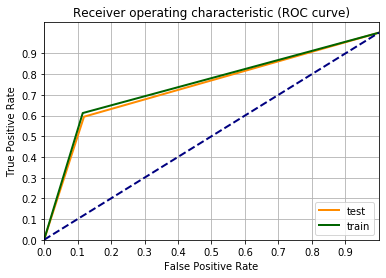

In [43]:
fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

calculate Area under the curve

Una metrica più semplice è la **confusion matrix**. Che può essere spiegata con il grafico sotto.<br>
Come si vede ho due assi, valore vero e valore predetto.<br>
Ogni esempio del dataset può essere inserito in una delle quattro classi:
- true positive (tp): il valore vero è 1 e il valore predetto è 1
- false positive (fp): il valore vero è 0 ma il valore predetto è 1
- true negative (tn): il valore vero è 0 e il valore predetto è 0
- false negative (fn): il valore vero è 1 ma il valore predetto è 0

Come si intuisce due delle classi sono correttamente classificate (true positive e true negative), mentre le altre due sono classificate erroneamente.

![title](https://www.1week4.com/wp-content/uploads/2019/07/logistic-regression1-e1562588720843.png)

Scikit-learn ci mette a disposizione la funzione confusion_matrix() per fare questo calcolo:

In [44]:
from sklearn.metrics import confusion_matrix

In [45]:
output_data_train = model.predict(input_data_train)
output_data_train = (output_data_train>0.5)

In [46]:
tn, fp, fn, tp = confusion_matrix(label_train, output_data_train ).ravel()
tn, fp, fn, tp

(6182, 807, 1362, 2149)

Con questi valori posso costruire altre metriche:

$
\begin{align}
&Accuratezza: \quad A = \frac{\text{nr. di esempi correttamente classificati}}{\text{nr. totale di esempi}} = \frac{tp+tn}{tp+tn+fn+fp} \cr\\
&Precisione: \quad P = \frac{\text{nr. di true positive}}{\text{nr. di predizioni positive}} = \frac{tp}{tp+fp} \cr\\
&Recall: \quad R = \frac{\text{nr. di true positive}}{\text{nr. veri positivi}} = \frac{tp}{tp+fn} \cr\\
&F_1 score: \quad F_1 = 2 \frac{P\cdot R}{P+R}
\end{align}
$

In [47]:
A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))

L'accuratezza è 79.3%
La precisione è 72.7%
Il recall è 61.2%
Il punteggio F1 è 66.5%


### SVM con kernel non lineare

Da scikit-learn importo il modello di SVM con Kernel arbitrario:

In [48]:
from sklearn.svm import SVC

radial basis function (rbl) kernel. [Link](https://scikit-learn.org/stable/modules/svm.html#kernel-functions) della pagina di scikit-learn

simile al kernel gaussiano

fare grafico della funzione


In [49]:
model = SVC(kernel="rbf", C=1.0, gamma='auto')

In [50]:
model.fit(input_data_train, label_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
output_data_train = model.predict(input_data_train)
output_data_test = model.predict(input_data_test)

In [52]:
fpr_train, tpr_train, _ = roc_curve(label_train,output_data_train)
fpr_test, tpr_test, _   = roc_curve(label_test ,output_data_test)

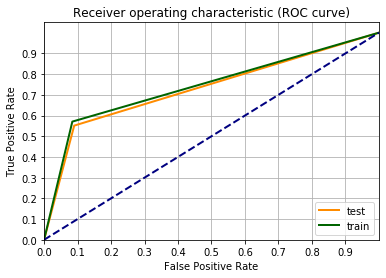

In [53]:
fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

In [54]:
tn, fp, fn, tp = confusion_matrix(label_test, output_data_test ).ravel()

In [55]:
A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))

L'accuratezza è 79.1%
La precisione è 75.2%
Il recall è 55.1%
Il punteggio F1 è 63.6%


In [56]:
model = SVC(kernel="rbf", C=100000, gamma=0.1)

In [57]:
model.fit(input_data_train, label_train)

SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [58]:
output_data_train = model.predict(input_data_train)
output_data_test = model.predict(input_data_test)

In [59]:
fpr_train, tpr_train, _ = roc_curve(label_train,output_data_train)
fpr_test, tpr_test, _   = roc_curve(label_test ,output_data_test)

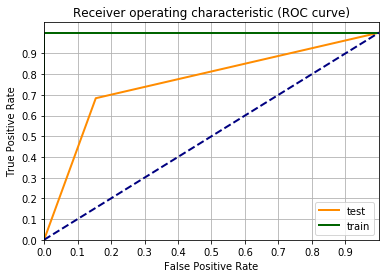

In [60]:
fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

In [61]:
tn, fp, fn, tp = confusion_matrix(label_test, output_data_test ).ravel()

In [62]:
A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))

L'accuratezza è 79.2%
La precisione è 68.6%
Il recall è 68.4%
Il punteggio F1 è 68.5%


use gridsearch to find best value of C and gamma of the rbf kernel

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
param = {'C':[1,100,1000,10000,50000,100000,500000,1000000],'gamma': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]}

In [65]:
svc = SVC(kernel="rbf")

In [66]:
gscv = GridSearchCV(svc, param, cv=3, verbose=1, n_jobs=-1)

In [ ]:
gscv.fit(input_data_train,label_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 13.9min


In [73]:
gscv.best_params_

{'C': 100000, 'gamma': 0.01}

In [ ]:
output_data_train = gscv.best_estimator_.fit(input_data_train, label_train)

In [64]:
??GridSearchCV

Init signature:
GridSearchCV(
    estimator,
    param_grid,
    scoring=None,
    fit_params=None,
    n_jobs=None,
    iid='warn',
    refit=True,
    cv='warn',
    verbose=0,
    pre_dispatch='2*n_jobs',
    error_score='raise-deprecating',
    return_train_score='warn',
)
Source:        
class GridSearchCV(BaseSearchCV):
    """Exhaustive search over specified parameter values for an estimator.

    Important members are fit, predict.

    GridSearchCV implements a "fit" and a "score" method.
    It also implements "predict", "predict_proba", "decision_function",
    "transform" and "inverse_transform" if they are implemented in the
    estimator used.

    The parameters of the estimator used to apply these methods are optimized
    by cross-validated grid-search over a parameter grid.

    Read more in the :ref:`User Guide <grid_search>`.

    Parameters
    ----------
    estimator : estimator object.
        This is assumed to implement the scikit-learn estimator interface.
  

Un punteggio F1 non molto al di sopra del 50% (probabilità di indovinare il lato di una moneta bilanciata) non è un gran punteggio. Vediamo se riesco a tirarne fuori qualcosa di più.

Ricordiamo come funziona la regressione logistica. Per semplificare consideriamo il caso di due ingressi $x1$ e $x2$. <br>
Gli ingressi sono combinati linearnemente con i pesi $w1$ e $w2$, un fattore bias $b$ viene sommato: $z=w_1 \cdot x_1 + w_2 \cdot x_2 + b$<br>
La somma viene applicata alla funzione sigmoid $\sigma(z)$, la cui uscita è compresa tra 0 e 1.<br>
Sul risultato della funzione sigmoid viene fatta la decisione:
\begin{equation}
\sigma(z) > 0.5 \implies y=1
\end{equation}
\begin{equation}
\sigma(z) \le 0.5 \implies y=0
\end{equation}

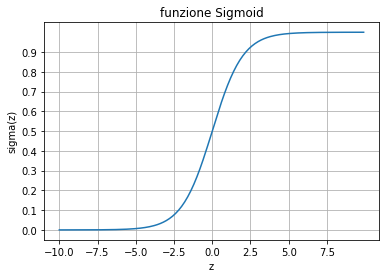

In [53]:
x = np.arange(-10,10,0.1)
x_tens = torch.from_numpy(x)
y = torch.sigmoid( x_tens )

plt.plot( x,y.numpy() )
plt.xticks(np.arange(-10, 10, 2.5))
plt.yticks(np.arange(0, 1, 0.1))
plt.grid(which='both')
plt.xlabel('z')
plt.ylabel('sigma(z)')
plt.title('funzione Sigmoid')
plt.show()

Come si vede dal grafico della funzione Sigmoid sopra, $\sigma(z)$ è maggiore di 0.5 se z > 0. Ovvero se:

\begin{equation}
w_1 \cdot x_1 + w_2 \cdot x_2 + b > 0
\end{equation}

La disequazione sopra definisce una regione dello spazio bidimensionale delimitata dalla retta:
$x_2 = -\frac{w_1}{w_2} x_1 - \frac{b}{w_2}$

Questa divisione dello spazio può andare bene in alcuni casi casi, per esempio nella situazione sotto la retta riesce a classificare abbastanza bene tra punti verdi e punti rossi.

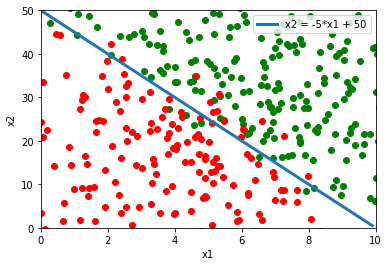

In [54]:
#Questo codice serve solo per la rappresentazione di un concetto
fgr2 = plt.figure()
x = np.arange(0,10,0.1)
y = -5*x + 50
# x1 = np.random()
x1 = 4 * np.random.randn(500)+5
y1 = 20 * np.random.randn(500)+25
yn = 5 * np.random.randn(500)
plt.plot(x,y, label="x2 = -5*x1 + 50", lw=3)
plt.scatter(x1[y1>(-5*x1+50+yn)],y1[y1>(-5*x1+50+yn)],color="green")
plt.scatter(x1[y1<=(-5*x1+50+yn)],y1[y1<=(-5*x1+50+yn)],color="red")
plt.xlim((0,10))
plt.ylim((0,50))
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

Invece nel caso rappresentato sotto, una retta non darebbe buoni risultati nella classificazione tra punti rossi e verdi. Serve invece qualcosa come una circonferenza. Ovvero qualcosa del tipo:
\begin{equation}
(x_1-x_{1,0})^2 + (x_2-x_{2,0})^2 = R^2
\end{equation}

Quindi occorre che nel modello di regressione compaiano anche i termini al quadrato degli ingressi $x_1$ e $x_2$.<br>
Questa tecnica si chiama features mapping, e consiste nel definire (mappare) come nuove features di ingresso le potenze degli ingressi originali e tutti i possibili prodotti. Per esempio, nel caso sotto potrei considerare come features di ingresso i seguenti:

\begin{equation}
input =
\begin{bmatrix}
x_1\cr
x_2\cr
x_1\cdot x_2\cr
x_1^2\cr
x_2^2
\end{bmatrix}
\end{equation}

Una volta introdotti i termini quadratici tra gli ingressi, l'ottimizzatore riuscirà (speriamo) a trovare la giusta combinazione di questi per ottenere il contorno di decisione di forma circolare come nella figura sottostante.

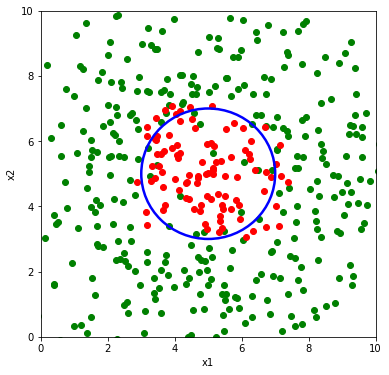

In [55]:
#Questo codice serve solo per la rappresentazione di un concetto
fig, ax = plt.subplots(figsize=(6,6))
x = np.arange(0,10,0.1)
y = -5*x + 50
# x1 = np.random()
x1 = 3 * np.random.randn(500)+5
y1 = 3 * np.random.randn(500)+5
yn = 2 * np.random.randn(500)
# plt.plot(x,y, label="x2 = -5*x1 + 50", lw=3)
extern = ((x1-5)**2 + (y1-5)**2 -2**2 > yn)
intern = ((x1-5)**2 + (y1-5)**2 -2**2 <= yn)
plt.scatter(x1[extern],y1[extern],color="green")
plt.scatter(x1[intern],y1[intern],color="red")
circle1 = plt.Circle((5, 5), 2, color='b', fill=False, lw=2.5)
ax.add_artist(circle1)
plt.xlim((0,10))
plt.ylim((0,10))
plt.xlabel('x1')
plt.ylabel('x2')
# plt.gca().set_aspect('equal', adjustable='box')
# plt.legend()
plt.show()

Per generare i termini non lineari di un numpy array x (ogni colonna una feature diversa) uso il codice sotto. La programmazione di questo mi ha dato abbastanza mal di testa, usatelo con cautela.

In [56]:
def generateNonLinearFeatures(x,max_exp):
#given a marix with features in column, generate a new matrix with all the polynomial combination up to max_exp

    import itertools

    terms = []
    num_feat = x.shape[1]
    
    #il prossimo comando genera una lista delle possibili combinazioni delle variabili fino al max_exp
    #Esempio: num_Feat=2 max_exp=2 genera:
    #[(0, 0),  (0, 1), (0, 2), (1, 1), (1, 2), (2, 2)] corrispondenti a:
    # x^0 x^0  x^0 x^1 x^0 x^2 x^1 x^1 x^1 x^2 x^2 x^2
    terms = list(itertools.combinations_with_replacement(list(range(num_feat+1)), max_exp))
    
#     for a in itertools.combinations_with_replacement(list(range(num_feat+1)), max_exp): #OLD
#         terms.append(a)


    if 'pol' in locals(): #rimuove la variabile pol se esiste già
        del pol

    for i in range(len(terms)): 
        polcol = np.ones(x.shape[0]).reshape(x.shape[0],1)
        sum=0
        for j in range(max_exp):
#             print(i,j) #for debug only
            sum=sum+int(terms[i][j])
            if terms[i][j]!=0:
                polcol = np.multiply(polcol,x[:,int(terms[i][j])-1].reshape(x.shape[0],1))
        if (sum!=0): #exclude case all zeros (0,0), don't add the column
            if 'pol' in locals():
                pol = np.column_stack([pol, polcol])
            else:
                pol = polcol

    return pol

Per generare le features non lineari decido di rinunciare alla codifica dei dottori perché sono 109 colonne che renderebbero il calcolo molto pesante. Potrei concatenare la lista alla fine senza termini non lineari. Per il momento la lascio fuori.  

Riparto dal dataframe dei pazienti, normalizzato:

In [57]:
lista_pazienti_norm2 = lista_pazienti_norm.drop(columns=['Diabetic','Physician','PatientID'])
# lista_pazienti_norm2.values

Genero i termini non lineari fino al secondo ordine, si noti che la funzione generateNonLinearFeatures necessita come argomento un array (non un dataframe) per cui devo usare l'attributo <strong>.values</strong>

In [58]:
lista_pazient_norm_nl = generateNonLinearFeatures(lista_pazienti_norm2.values,2)

Ridefinisco la label e verifico che la lunghezza dei vettori sia corretta

In [59]:
label = lista_pazienti_norm.Diabetic.values
lista_pazient_norm_nl.shape, label.shape

((15000, 44), (15000,))

Divido il dataset in test e train:

In [60]:
lista_pazienti_norm_nl_train, lista_pazienti_norm_nl_test, label_train, label_test = train_test_split(lista_pazient_norm_nl, label, test_size=0.3)

lista_pazienti_norm_nl_train.shape, lista_pazienti_norm_nl_test.shape, label_train.shape, label_test.shape

((10500, 44), (4500, 44), (10500,), (4500,))

Converto gli array in tensori con elementi float:

In [61]:
input_data_train_tens = torch.from_numpy(lista_pazienti_norm_nl_train).type(dtype=torch.float)
input_data_test_tens = torch.from_numpy(lista_pazienti_norm_nl_test).type(dtype=torch.float)
label_train_tens = torch.from_numpy(label_train).type(dtype=torch.float).view(-1,1)
label_test_tens = torch.from_numpy(label_test).type(dtype=torch.float).view(-1,1)

Sono un po' paranoico con le verifiche:

In [62]:
input_data_train_tens.shape, label_train_tens.shape

(torch.Size([10500, 44]), torch.Size([10500, 1]))

Ridefinisco il modello sequenziale con il giusto numero di ingressi:

In [63]:
model_logreg = nn.Sequential(
    nn.Linear(input_data_train_tens.shape[1],1), 
    nn.Sigmoid()
)

definisco l'ottimizzatore

In [64]:
learning_rate = 0.1
optimizer = torch.optim.Adam(model_logreg.parameters(), lr = learning_rate)

e il loop di training del modello

In [65]:
for i in range(1000):
    output_data_train = model_logreg( input_data_train_tens ) #calcolo l'uscita
    loss = error(output_data_train, label_train_tens)         #calcolo l'errore
    loss.backward()        #calcolo del gradiente
    optimizer.step()       #aggiornamento ei parametri
    optimizer.zero_grad()  #azzeramento del gradiente
    if np.mod(i,100)==0:
        print(loss)

tensor(0.6992, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4006, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3841, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3790, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3769, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3758, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3749, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3743, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3737, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3732, grad_fn=<BinaryCrossEntropyBackward>)


calcolo l'uscita per il dataset si test, per il dataset di train ce l'ho già dal loop precedente:

In [66]:
output_data_test = model_logreg( input_data_test_tens )

Calcolo e grafico le curve ROC 

In [67]:
fpr_train, tpr_train, _ = roc_curve(label_train_tens,output_data_train.detach())
fpr_test, tpr_test, _   = roc_curve(label_test_tens ,output_data_test.detach())

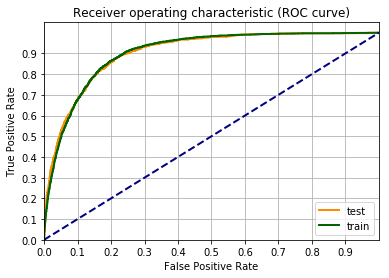

In [68]:
fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

Applico la funzione di decisione della classe:

In [69]:
# output_data_train = model_logreg( input_data_train_tens )
# output_data_train_bin = (output_data_train.detach()>0.5).numpy()
output_data_test_bin = (output_data_test.detach()>0.5).numpy()

calcolo la matrice di confusione:

In [70]:
tn, fp, fn, tp = confusion_matrix(label_test_tens, output_data_test_bin ).ravel()

e le quantità ad essa connesse:

In [71]:
A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))

L'accuratezza è 82.6%
La precisione è 77.2%
Il recall è 69.0%
Il punteggio F1 è 72.9%


Quindi aggiungendo i termini quadratici il punteggio F1 è salito dal 66% al 73%.

Proviamo ad aggiungere i termini al cubo. Ovviamente una cosa intelligente sarebbe quella di raccogliere tutti gli step in una funzione. Cosa che non farò, affidandomi al più veloce CUT and PASTE di Jupyter.

tensor(0.6846, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3778, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3484, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3257, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3087, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2959, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2858, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2777, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2710, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2656, grad_fn=<BinaryCrossEntropyBackward>)


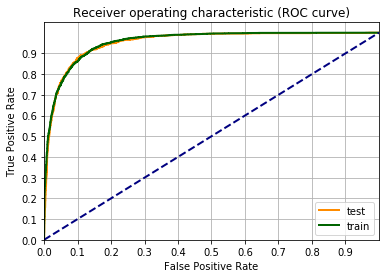

L'accuratezza è 89.2%
La precisione è 85.4%
Il recall è 80.9%
Il punteggio F1 è 83.1%


In [72]:
lista_pazient_norm_nl = generateNonLinearFeatures(lista_pazienti_norm2.values,3)
label = lista_pazienti_norm.Diabetic.values
lista_pazienti_norm_nl_train, lista_pazienti_norm_nl_test, label_train, label_test = train_test_split(lista_pazient_norm_nl, label, test_size=0.3)

input_data_train_tens = torch.from_numpy(lista_pazienti_norm_nl_train).type(dtype=torch.float)
input_data_test_tens = torch.from_numpy(lista_pazienti_norm_nl_test).type(dtype=torch.float)
label_train_tens = torch.from_numpy(label_train).type(dtype=torch.float).view(-1,1)
label_test_tens = torch.from_numpy(label_test).type(dtype=torch.float).view(-1,1)

model_logreg = nn.Sequential(
    nn.Linear(input_data_train_tens.shape[1],1), 
    nn.Sigmoid()
)

learning_rate = 0.1
optimizer = torch.optim.Adam(model_logreg.parameters(), lr = learning_rate)

for i in range(1000):
    output_data_train = model_logreg( input_data_train_tens ) #calcolo l'uscita
    loss = error(output_data_train, label_train_tens)         #calcolo l'errore
    loss.backward()        #calcolo del gradiente
    optimizer.step()       #aggiornamento ei parametri
    optimizer.zero_grad()  #azzeramento del gradiente
    if np.mod(i,100)==0:
        print(loss)

output_data_test = model_logreg( input_data_test_tens )

fpr_train, tpr_train, _ = roc_curve(label_train_tens,output_data_train.detach())
fpr_test, tpr_test, _   = roc_curve(label_test_tens ,output_data_test.detach())

fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

# output_data_train = model_logreg( input_data_train_tens )
# output_data_train_bin = (output_data_train.detach()>0.5).numpy()
output_data_test_bin = (output_data_test.detach()>0.5).numpy()

tn, fp, fn, tp = confusion_matrix(label_test_tens, output_data_test_bin ).ravel()

A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))

Sembra che il gioco funzioni piuttosto bene, sono passato da un F1 di 73% ad uno di 83%. Vediamo fino a dove posso spingermi.

tensor(0.7015, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3381, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2934, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2707, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2567, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2471, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2401, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2348, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2272, grad_fn=<BinaryCrossEntropyBackward>)


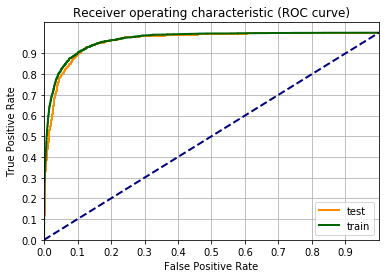

L'accuratezza è 89.7%
La precisione è 87.3%
Il recall è 81.8%
Il punteggio F1 è 84.5%


In [73]:
lista_pazient_norm_nl = generateNonLinearFeatures(lista_pazienti_norm2.values,4)
label = lista_pazienti_norm.Diabetic.values
lista_pazienti_norm_nl_train, lista_pazienti_norm_nl_test, label_train, label_test = train_test_split(lista_pazient_norm_nl, label, test_size=0.3)

input_data_train_tens = torch.from_numpy(lista_pazienti_norm_nl_train).type(dtype=torch.float)
input_data_test_tens = torch.from_numpy(lista_pazienti_norm_nl_test).type(dtype=torch.float)
label_train_tens = torch.from_numpy(label_train).type(dtype=torch.float).view(-1,1)
label_test_tens = torch.from_numpy(label_test).type(dtype=torch.float).view(-1,1)

model_logreg = nn.Sequential(
    nn.Linear(input_data_train_tens.shape[1],1), 
    nn.Sigmoid()
)

learning_rate = 0.1
optimizer = torch.optim.Adam(model_logreg.parameters(), lr = learning_rate)

for i in range(1000):
    output_data_train = model_logreg( input_data_train_tens ) #calcolo l'uscita
    loss = error(output_data_train, label_train_tens)         #calcolo l'errore
    loss.backward()        #calcolo del gradiente
    optimizer.step()       #aggiornamento ei parametri
    optimizer.zero_grad()  #azzeramento del gradiente
    if np.mod(i,100)==0:
        print(loss)

output_data_test = model_logreg( input_data_test_tens )

fpr_train, tpr_train, _ = roc_curve(label_train_tens,output_data_train.detach())
fpr_test, tpr_test, _   = roc_curve(label_test_tens ,output_data_test.detach())

fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

# output_data_train = model_logreg( input_data_train_tens )
# output_data_train_bin = (output_data_train.detach()>0.5).numpy()
output_data_test_bin = (output_data_test.detach()>0.5).numpy()

tn, fp, fn, tp = confusion_matrix(label_test_tens, output_data_test_bin ).ravel()

A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))

Da 83% a 84.5%, sono quasi al limite delle possibilità. Proviamo un altro step. 

tensor(0.6947, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3083, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2671, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2478, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2362, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2285, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2229, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2187, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2154, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.2127, grad_fn=<BinaryCrossEntropyBackward>)


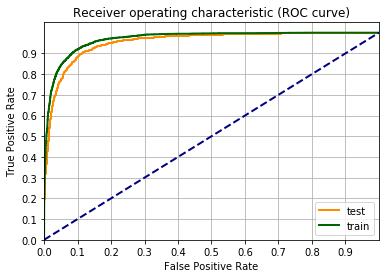

L'accuratezza è 89.4%
La precisione è 86.4%
Il recall è 82.1%
Il punteggio F1 è 84.2%


In [74]:
lista_pazient_norm_nl = generateNonLinearFeatures(lista_pazienti_norm2.values,5)
label = lista_pazienti_norm.Diabetic.values
lista_pazienti_norm_nl_train, lista_pazienti_norm_nl_test, label_train, label_test = train_test_split(lista_pazient_norm_nl, label, test_size=0.3)

input_data_train_tens = torch.from_numpy(lista_pazienti_norm_nl_train).type(dtype=torch.float)
input_data_test_tens = torch.from_numpy(lista_pazienti_norm_nl_test).type(dtype=torch.float)
label_train_tens = torch.from_numpy(label_train).type(dtype=torch.float).view(-1,1)
label_test_tens = torch.from_numpy(label_test).type(dtype=torch.float).view(-1,1)

model_logreg = nn.Sequential(
    nn.Linear(input_data_train_tens.shape[1],1), 
    nn.Sigmoid()
)

learning_rate = 0.1
optimizer = torch.optim.Adam(model_logreg.parameters(), lr = learning_rate)

for i in range(1000):
    output_data_train = model_logreg( input_data_train_tens ) #calcolo l'uscita
    loss = error(output_data_train, label_train_tens)         #calcolo l'errore
    loss.backward()        #calcolo del gradiente
    optimizer.step()       #aggiornamento ei parametri
    optimizer.zero_grad()  #azzeramento del gradiente
    if np.mod(i,100)==0:
        print(loss)

output_data_test = model_logreg( input_data_test_tens )

fpr_train, tpr_train, _ = roc_curve(label_train_tens,output_data_train.detach())
fpr_test, tpr_test, _   = roc_curve(label_test_tens ,output_data_test.detach())

fgr1 = plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange', label="test", lw=lw)
plt.plot(fpr_train, tpr_train, color='darkgreen', label="train", lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.05])
plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 1, 0.1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.grid(which='both')
plt.show()

# output_data_train = model_logreg( input_data_train_tens )
# output_data_train_bin = (output_data_train.detach()>0.5).numpy()
output_data_test_bin = (output_data_test.detach()>0.5).numpy()

tn, fp, fn, tp = confusion_matrix(label_test_tens, output_data_test_bin ).ravel()

A = (tp+tn)/(tp+tn+fn+fp)
P = tp/(tp+fp)
R = tp/(tp+fn)
F1 = 2*(P*R)/(P+R)
print('L\'accuratezza è %0.1f%%' %(A*100))
print('La precisione è %0.1f%%' %(P*100))
print('Il recall è %0.1f%%' %(R*100))
print('Il punteggio F1 è %0.1f%%' %(F1*100))

Il valore di F1 è rimasto intorno al 84%, quindi nessun miglioramento nel passare dalla quarta potenza alla quinta. Inoltre c'è una certa distanza tra la curva riguardante i dati di train e quella di test. Questo indica che c'è un certo overfitting.

## Riferimenti

1. Coursera.org, [Machine Learning](https://www.coursera.org/learn/machine-learning), in inglese
2. 